### 연관성 분석 - Apriori.

In [29]:
# 다음 모듈을 설치한다.
!pip install mlxtend==0.18.0

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

#### 1. 데이터를 읽어와서 탐색한다.

In [31]:
# 구글 드라이브 마운트.
from google.colab import drive
drive.mount('/content/drive')  # 절차를 따라서 한다.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
df = pd.read_csv("/content/drive/MyDrive/인공지능사관학교/빅데이터/03_확률 모델링_업데이트/data/data_basket.csv")

In [33]:
df.shape

(9835, 1)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9835 entries, 0 to 9834
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   items   9835 non-null   object
dtypes: object(1)
memory usage: 77.0+ KB


In [35]:
df.head()

,items
0,"{citrus fruit,semi-finished bread,margarine,re..."
1,"{tropical fruit,yogurt,coffee}"
2,{whole milk}
3,"{pip fruit,yogurt,cream cheese ,meat spreads}"
4,"{other vegetables,whole milk,condensed milk,lo..."


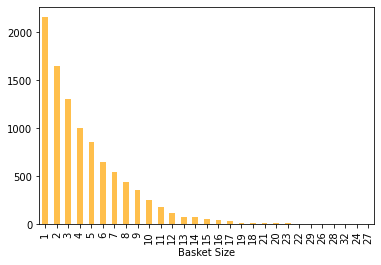

In [36]:
# 장바구니 크기의 도수표를 만들고 시각화로 출력한다.
size_frequencies = df['items'].apply(lambda x: x.count(',') +1).value_counts()
size_frequencies.plot.bar(color = 'orange', alpha=0.7)
plt.xlabel("Basket Size")
plt.show()

#### 2. 데이터 전처리.

**2.1. 전처리 준비.**

In [37]:
# 문자열에서 중괄호를 제거한다.
sr = df['items'].apply(lambda x: x[1:-1])

In [38]:
# List of List 로 변환한다.
my_data = []
for x in sr:
    a_basket = x.split(",")
    if len(a_basket) > 1:                           # 단 한개의 아이템만 있는 장바구니는 필요 없다.
        my_data += [a_basket]

In [39]:
# 장바구니의 갯수.
print(len(my_data))

7676


In [40]:
# 첫 3개의 장바구니를 출력해 본다.
my_data[:3]

[['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups'],
 ['tropical fruit', 'yogurt', 'coffee'],
 ['pip fruit', 'yogurt', 'cream cheese ', 'meat spreads']]

**2.2. Encoding된 형태로 변환.**

In [41]:
# TransactionEncoder 객체 생성.
my_te = TransactionEncoder()
my_data_array = my_te.fit_transform(my_data)       
type(my_data_array)                              # Numpy 배열 객체 확인.

numpy.ndarray

In [42]:
# Numpy 배열의 shape.
# 출력하기에는 크다.
my_data_array.shape

(7676, 169)

In [43]:
# 학습된 columns_의 일부를 출력해 본다.
print(len(my_te.columns_))       # columns_는 list 이다. 이것의 길이를 출력해 본다.
print(my_te.columns_[:10])

169
['Instant food products', 'UHT-milk', 'abrasive cleaner', 'artif. sweetener', 'baby cosmetics', 'baby food', 'bags', 'baking powder', 'bathroom cleaner', 'beef']


In [44]:
# Numpy 배열을 역으로 변환할 수도 있다.
my_te.inverse_transform(my_data_array)[:3]

[['citrus fruit', 'margarine', 'ready soups', 'semi-finished bread'],
 ['coffee', 'tropical fruit', 'yogurt'],
 ['cream cheese ', 'meat spreads', 'pip fruit', 'yogurt']]

In [45]:
# 이제는 데이터 프레임으로 변환한다.
df_processed = pd.DataFrame(data=my_data_array, columns = my_te.columns_)
print(df_processed.shape)            # Shape 출력.        
df_processed.head(5)                 # 상단 출력.

(7676, 169)


,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,...,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,sound storage medium,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
4,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False


#### 3. Apriori 알고리즘 적용.

In [52]:
# 지지도(support)가 최소값 이상인 항목들만 걸러낸다.
my_frequent_patterns = apriori(df_processed, min_support=0.001, use_colnames=True)

In [54]:
my_frequent_patterns

,support,itemsets
0,0.009901,(Instant food products)
1,0.041558,(UHT-milk)
2,0.004429,(abrasive cleaner)
3,0.004039,(artif. sweetener)
4,0.022277,(baking powder)
...,...,...
19972,0.001694,"(rolls/buns, root vegetables, other vegetables..."
19973,0.001042,"(rolls/buns, other vegetables, whole milk, yog..."
19974,0.001433,"(root vegetables, other vegetables, whole milk..."
19975,0.001042,"(root vegetables, white bread, other vegetable..."


In [47]:
# 항목의 지지도(support)가 높은 순서대로 출력해 본다.
# 항목의 지지도(support)는 항목이 포함된 basket의 비율을 의미한다.
my_frequent_patterns.sort_values(by="support", ascending=False).head(100)

,support,itemsets
156,0.311621,(whole milk)
97,0.239838,(other vegetables)
116,0.221470,(rolls/buns)
132,0.203101,(soda)
157,0.173528,(yogurt)
...,...,...
66,0.031006,(hard cheese)
8,0.029964,(beverages)
3133,0.029703,"(shopping bags, other vegetables)"
12333,0.029703,"(whole milk, root vegetables, other vegetables)"


In [48]:
# 지지도(support)가 높은 항목들을 기반으로 연관 규칙을 만들어 본다.
# 신뢰도(confidence)가 최소값 이상인 규칙들만 걸러낸다.
my_rules = association_rules(my_frequent_patterns, metric="confidence",min_threshold=0.75)

In [56]:
my_rules[my_rules.lift > 3.0]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(pork, Instant food products)",(other vegetables),0.001303,0.239838,0.001042,0.800000,3.335578,0.000730,3.800808
4,"(hard cheese, beef)",(other vegetables),0.001563,0.239838,0.001172,0.750000,3.127105,0.000798,3.040646
6,"(mayonnaise, beef)",(other vegetables),0.001563,0.239838,0.001172,0.750000,3.127105,0.000798,3.040646
7,"(mayonnaise, beef)",(root vegetables),0.001563,0.136399,0.001172,0.750000,5.498567,0.000959,3.454403
8,"(sweet spreads, beef)",(yogurt),0.001303,0.173528,0.001042,0.800000,4.610210,0.000816,4.132361
...,...,...,...,...,...,...,...,...,...
1844,"(whole milk, pip fruit, yogurt, whipped/sour c...",(other vegetables),0.001433,0.239838,0.001172,0.818182,3.411387,0.000829,4.180888
1845,"(root vegetables, white bread, other vegetable...",(yogurt),0.001303,0.173528,0.001042,0.800000,4.610210,0.000816,4.132361
1846,"(root vegetables, white bread, other vegetable...",(whole milk),0.001042,0.311621,0.001042,1.000000,3.209030,0.000717,inf
1847,"(root vegetables, white bread, whole milk, yog...",(other vegetables),0.001172,0.239838,0.001042,0.888889,3.706198,0.000761,6.841454


In [49]:
# 향상도(lift)가 1 이상인 연관 규칙들만 걸러낸다.
my_rules = my_rules[my_rules.lift > 1.0]
# 향상도(lift)가 높은 순서대로 연관 규칙을 출력해 본다.
my_rules[['antecedents', 'consequents','support','confidence','lift']].sort_values(by='lift',ascending=False ).head(10)

,antecedents,consequents,support,confidence,lift
1797,"(whole milk, butter, white bread, tropical fruit)","(yogurt, other vegetables)",0.001042,1.000000,17.976581
1812,"(other vegetables, whole milk, yogurt, whipped...",(cream cheese ),0.001172,0.818182,16.270372
1484,"(domestic eggs, hard cheese, whipped/sour cream)","(root vegetables, other vegetables)",0.001042,0.888889,14.641869
1223,"(whole milk, hard cheese, whipped/sour cream, ...",(butter),0.001042,1.000000,14.374532
1063,"(rolls/buns, root vegetables, yogurt, butter)",(beef),0.001042,0.888889,13.924717
1282,"(butter, white bread, tropical fruit)","(yogurt, other vegetables)",0.001303,0.769231,13.828139
1292,"(butter, yogurt, rice)","(whole milk, root vegetables)",0.001042,0.800000,12.766736
334,"(hard cheese, whipped/sour cream, tropical fruit)",(butter),0.001172,0.818182,11.760981
1218,"(whipped/sour cream, hard cheese, other vegeta...",(butter),0.001042,0.800000,11.499625
350,"(whole milk, onions, long life bakery product)",(butter),0.001042,0.800000,11.499625


In [58]:
# 왼편, 오른편의 항목수를 명시해서 연관 규칙을 출력해 본다.
n_left = 3
n_right = 1
my_rules_small = my_rules[(my_rules.antecedents.apply(lambda x: len(x)) == n_left) & (my_rules.consequents.apply(lambda x: len(x)) == n_right)]
my_rules_small[['antecedents', 'consequents','support','confidence','lift']].sort_values(by='lift',ascending=False ).head(10)

,antecedents,consequents,support,confidence,lift
334,"(hard cheese, whipped/sour cream, tropical fruit)",(butter),0.001172,0.818182,11.760981
350,"(whole milk, onions, long life bakery product)",(butter),0.001042,0.800000,11.499625
204,"(soda, red/blush wine, liquor)",(bottled beer),0.001042,1.000000,11.422619
346,"(butter, other vegetables, ice cream)",(whipped/sour cream),0.001042,0.800000,9.043888
525,"(citrus fruit, misc. beverages, fruit/vegetabl...",(tropical fruit),0.001042,1.000000,7.607532
464,"(frankfurter, citrus fruit, chicken)",(root vegetables),0.001172,0.900000,6.598281
947,"(whole milk, onions, oil)",(root vegetables),0.001172,0.900000,6.598281
695,"(domestic eggs, hard cheese, whipped/sour cream)",(root vegetables),0.001042,0.888889,6.516821
1036,"(rice, yogurt, tropical fruit)",(root vegetables),0.001042,0.888889,6.516821
883,"(tropical fruit, pip fruit, herbs)",(root vegetables),0.001042,0.888889,6.516821
